# Week 2

## Estimating parameters - Likelihood

Estimator: a function, unknown parameter, $\theta$, estimate (resulting value of parameter), $\hat{\theta}$.

A good estimator should be robust so as not to be sensitive to background or outliers (eg. the mean is sensitive to outliers, the median isn't).

Unknown parameter: $\vec{\lambda}=(\lambda_1, \lambda_2, ...)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
from scipy.stats import binom, poisson, norm
from iminuit import Minuit
import iminuit
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
r = np.random

sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef
import ExternalFunctions as ef

import seaborn as sns
from matplotlib import style
plt.style.use("seaborn-white")
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [2]:
import seaborn as sns
colors = sns.color_palette('tab20',5 , 1)

## Mini exercise

In [19]:
mu = [1.25, 1.3]
sig = [np.sqrt(0.11), np.sqrt(0.5)]
N = 4

norm1 = r.normal(mu[0], sig[0], N)
norm2 = r.normal(mu[1], sig[1], N)
norm = [norm1, norm2]

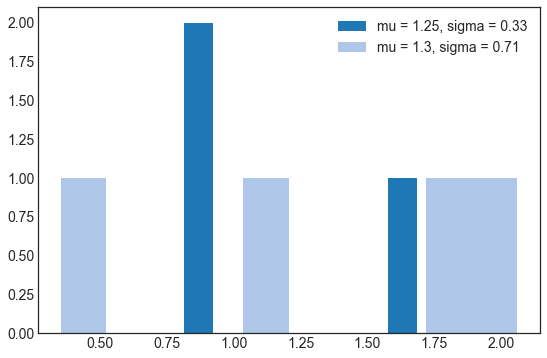

In [21]:
fig, ax = plt.subplots(figsize=(9,6))
for i in range(2):
    ax.hist(norm[i], color=colors[i], label=f'mu = {mu[i]}, sigma = {np.round(sig[i],2)}')
    
ax.legend();

In [75]:
# Likelihood

x = [1.01, 1.3, 1.35, 1.44]

def Gauss(x, mu, sigma):
    gauss = norm.pdf(x, mu, sigma)  
    # normalized (Gaussian always is)
    return gauss

def LH(x, pdf, par, log):
    if log == False:
        return  np.prod(pdf(x, *par))
    elif log == True:
        return  np.sum(np.log(pdf(x, *par)))


In [32]:
LH1 = LH(x, Gauss, [mu[0], sig[0]])
LH2 = LH(x, Gauss, [mu[1], sig[1]])
print(LH1, LH2)
# From this we would choose LH1 (max LH)

1.2918411137616792 0.09111254560865162


We now move from Likelihood to ln(Likelihood) (LLH). We now want to minimize the LLH. 

## Exercise 1

In [288]:
# Raster scan: calculate test statistics at different values of the parameters to find the best LLH value. 
def LLH_landscape(ax, x, func, scanx, scany, parx_name, pary_name, delta=False):
    
    LH_vals = np.zeros((len(scany),len(scanx)))
    cbar_label = r'-LLH'

    for i in range(len(scany)):
        for j in range(len(scanx)):
            LH_vals[i,j] = -LH(x, func, [scanx[j], scany[i]], log=True)
       
    if delta == True:
        # difference in LLH from best-fit LLH-value
        LH_vals -= np.min(LH_vals)
        cbar_label = r'$\Delta LLH$'
        
    # plot
    im = ax.imshow(LH_vals, cmap='jet_r')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    ax.set_xlabel(parx_name)
    ax.set_ylabel(pary_name)
    ax.set_xticks(np.arange(0,len(scanx))[::int(len(scanx)/10)])
    ax.set_xticklabels(np.round(scanx[::int(len(scanx)/10)],2))
    ax.set_yticks(np.arange(0,len(scany))[::int(len(scany)/10)])
    ax.set_yticklabels(np.round(scany[::int(len(scany)/10)],2))
    cbar.set_label(cbar_label)
    
    max_indices = np.unravel_index(np.argmax(LH_vals, axis=None), LH_vals.shape)
    best_fits = [scanx[max_indices[1]], scany[max_indices[0]],2]
    
    return LH_vals, best_fits

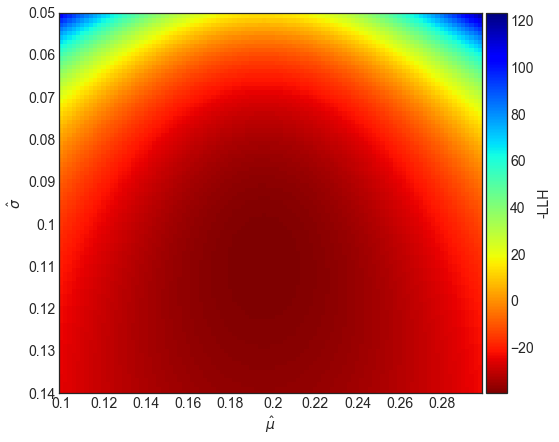

In [289]:
mu_true = 0.2
sig_true = 0.1
norm_gen = r.normal(mu_true, sig_true, 50)

n_scans = 100
mu_scan = np.linspace(0.1,0.3,n_scans)
sig_scan = np.linspace(0.05,0.15,n_scans)
pary_name = '$\hat{\sigma}$'
parx_name = r'$\hat{\mu}$'

fig, ax = plt.subplots(figsize=(10,7))
LH_vals = LLH_landscape(ax, norm_gen, Gauss, mu_scan, sig_scan, parx_name, pary_name);

In [94]:
max_indices = np.unravel_index(np.argmax(LH_vals, axis=None), LH_vals.shape)
print('Best-fit values:', 'mu=', np.round(mu_scan[max_indices[1]],2), ', sigma=', np.round(sig_scan[max_indices[0]],2))

Best-fit values: mu= 0.2 , sigma= 0.09


In [95]:
# maximum likelihood estimator
MLE = LH(norm_gen, Gauss, [mu_true, sig_true], True)

print('Max LH:', np.max(LH_vals), ', analytic MLE:', MLE)

Max LH: 48.74308545523402 , analytic MLE: 48.326183122430386


## Exercise 2

In [3]:
# minimize -LLH

def fit_func(x, alpha, beta):
    f = 1 + alpha*x + beta*x**2
    # normalize:
    A = 2/3 *(beta+3)
    f_norm = f/A
    return f_norm


def acc_rej(x_min, x_max, f, params, N_points):
    x = np.linspace(x_min, x_max, 10000)
    x_acc = np.zeros(N_points)
    N = 1
    while N<N_points:
        x_rand = r.uniform(x_min, x_max)
        y_rand = r.uniform(0, max(f(x, *params)))
        if y_rand <= f(x_rand, *params):
            x_acc[N] = x_rand
            N += 1
            
    return x_acc

In [52]:
N_mc = 2000
x = np.linspace(-1,1, N_mc)
alpha_true, beta_true = 0.1, 0.5

x_mc = acc_rej(-1, 1, fit_func, [alpha_true, beta_true], N_mc)

In [159]:
def LLH_fit(func, x, params, guesses, limits = None):
    steps_taken = []
    
    def LLH(params):
        LLH_val = np.sum(np.log(func(x, *params)))
        steps_taken.append(params)
        return -LLH_val

    LLH.errordef = 1.0
    minuit = Minuit(LLH, guesses, name=tuple(params))
    
    if limits != None:
        for i in range(len(params)):
            minuit.limits[params[i]] = limits[i]
            
    minuit.migrad()
    LLH_fit = minuit.fval
    par = minuit.values[:]
    par_err = minuit.errors[:] 
    par_name = minuit.parameters[:]

    return par, par_err, steps_taken

In [162]:
fit_vals, fit_err, steps = LLH_fit(fit_func, x_mc, ['alpha', 'beta'], [0.5, 0.5], [(-0.2, 1), (0,1)])
print('alpha=', fit_vals[0], 'beta=', fit_vals[1])

alpha= 0.02615052469692636 beta= 0.6414827383890076


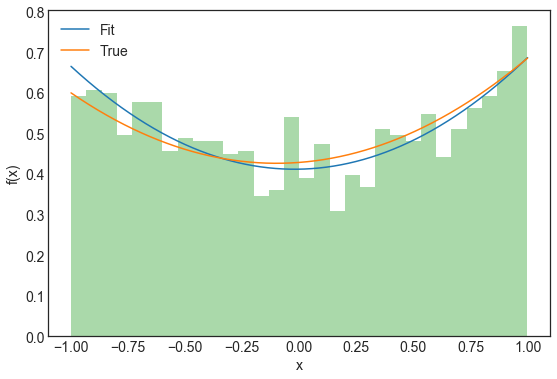

In [55]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(x, fit_func(x, fit_vals[0], fit_vals[1]), label='Fit')
ax.plot(x, fit_func(x, alpha_true, beta_true), label='True')
ax.hist(x_mc, bins=30, density=True, alpha=0.4)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()

## Exercise 3

In [100]:
# new parameter values and new MC values
alpha3, beta3 = 0.6, 0.5
x_mc3 = acc_rej(-1, 1, fit_func, [alpha3, beta3], N_mc)

alpha= 0.5933234347356615 beta= 0.5406978178416427


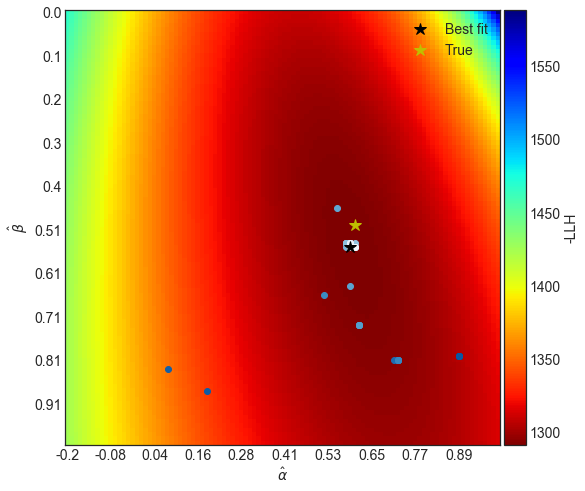

In [297]:
alpha_scan = np.linspace(-0.2, 1, 100)
beta_scan = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
LLH_vals, best_fits = LLH_landscape(ax, x_mc3, fit_func, alpha_scan, beta_scan, r'$\hat{\alpha}$', r'$\hat{\beta}$');

fit_vals3, fit_err3, steps3 = LLH_fit(fit_func, x_mc3, ['alpha', 'beta'], [0.89, 0.8], [(-0.2, 1), (0,1)])
print('alpha=', fit_vals3[0], 'beta=', fit_vals3[1])

# track colors
track_colors = sns.color_palette('Blues_r',len(steps3))

# plot the minimizer steps
for step in range(len(steps3)):
    ax.scatter(find_nearest(alpha_scan, steps3[step][0]), find_nearest(beta_scan, steps3[step][1]), color=track_colors[step])

# plot true and best fit
def find_nearest(a, a0):
    "index in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

#ax.plot(np.where(alpha_scan==best_fits[0])[0][0],np.where(beta_scan==best_fits[1])[0][0], 'k*', label='Best fit')
ax.plot(find_nearest(alpha_scan, fit_vals3[0]), find_nearest(beta_scan, fit_vals3[1]), 'k*', markersize=12, label='Best fit')
ax.plot(find_nearest(alpha_scan, alpha3), find_nearest(beta_scan, beta3), 'y*', markersize=12, label='True')

ax.legend();

Contours

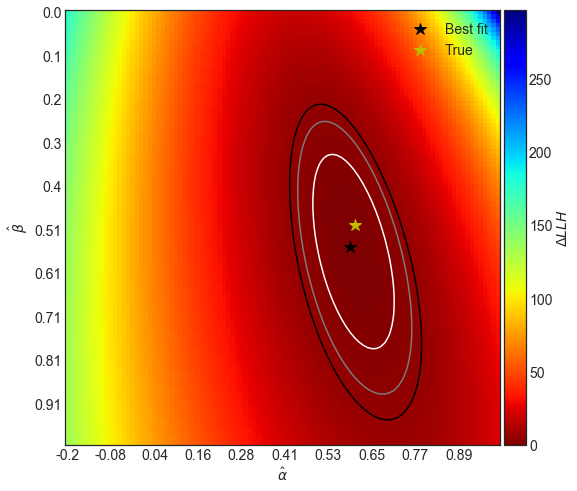

In [291]:
x = y = np.arange(0,100)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(11,8))

Z, _ = LLH_landscape(ax, x_mc3, fit_func, alpha_scan, beta_scan, r'$\hat{\alpha}$', r'$\hat{\beta}$', delta=True);
ax.contour(X, Y, Z, [2.3,4.5,6])
ax.plot(find_nearest(alpha_scan, fit_vals3[0]), find_nearest(beta_scan, fit_vals3[1]), 'k*', markersize=12, label='Best fit')
ax.plot(find_nearest(alpha_scan, alpha3), find_nearest(beta_scan, beta3), 'y*', markersize=12, label='True')
ax.legend();

# Bayesian Statistics

In [299]:
# Astro example

P_plus_1 = 0.8  # Likelihood of correctly identifying a radio loud AGN (1)
P_plus_2 = 0.3  # likelihood of misidentifying (false positive) a non-radio loud AGN (2)
P_1 = 0.1       # type 1 in AGN population
P_2 = 0.9       # type 2 in AGN population


# prob. that an AGN that is observed as radio loud is actually radio loud (1):
P_1_plus = P_plus_1 * P_1 / (P_plus_1*P_1 + P_plus_2*P_2)   # discrete bayes
print(P_1_plus)

0.2285714285714286

In [301]:
# decreasing false positives by a factor of 2
P_new1 = P_plus_1 * P_1 / (P_plus_1*P_1 + P_plus_2/2*P_2)  

# improving the radio loud AGN selection by 60%
P_new2 = P_plus_1 * P_1*1.6 / (P_plus_1*P_1*1.6 + P_plus_2*P_2)

print(P_new1, P_new2)
# first is best

0.372093023255814 0.3216080402010051


## Exercise 1

In [36]:
from scipy.stats import hypergeom, norm

n = 60
K = 100
k = 10

# hypergeometric function - sampling without replacement
# pmf(k, M, n, N, loc=0)
# M total number, n number of tagged fish, N extracted
N = np.linspace(150, 2000, 1000)

def posterior(N, k, K, n, prior, marginal):

    likelihoods = np.zeros(len(N))

    for i in range(len(N)):
        likelihoods[i] = hypergeom.pmf(k, N[i], K, n)
        
    posteriors = likelihoods*prior/marginal
    
    return likelihoods, posteriors

likelihoods1, posteriors1 = posterior(N, k, K, n, 1, 1)
likelihoods46, posteriors46 = posterior(N, k, K, n, 0.4, 0.6)

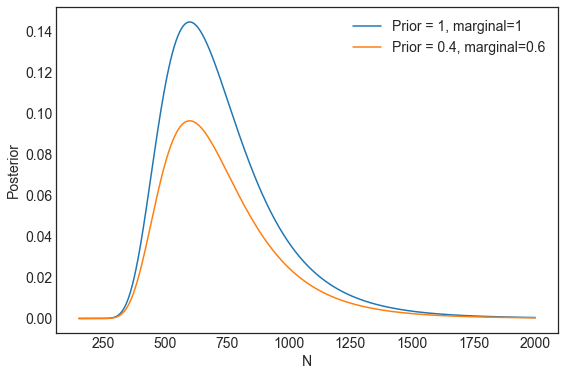

In [14]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(N,posteriors1, label='Prior = 1, marginal=1')
ax.plot(N,posteriors46, label='Prior = 0.4, marginal=0.6')
ax.set_xlabel('N')
ax.set_ylabel('Posterior')
ax.legend()

## Exercise 2

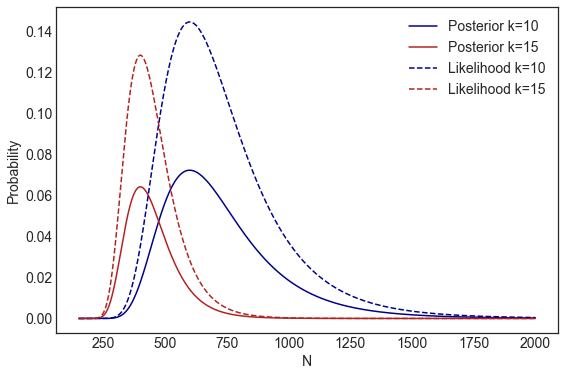

In [29]:
likelihoods_k10, posteriors_k10 = posterior(N, 10, K, n, 0.5, 1)
likelihoods_k15, posteriors_k15 = posterior(N, 15, K, n, 0.5, 1)
# Posteriors not normalized

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(N,posteriors_k10, label='Posterior k=10', c='darkblue')
ax.plot(N,posteriors_k15, label='Posterior k=15', c='firebrick')
ax.plot(N,likelihoods_k10, label='Likelihood k=10', linestyle='dashed', c='darkblue')
ax.plot(N,likelihoods_k15, label='Likelihood k=15', linestyle='dashed', c='firebrick')
ax.set_xlabel('N')
ax.set_ylabel('Probability')
ax.legend()

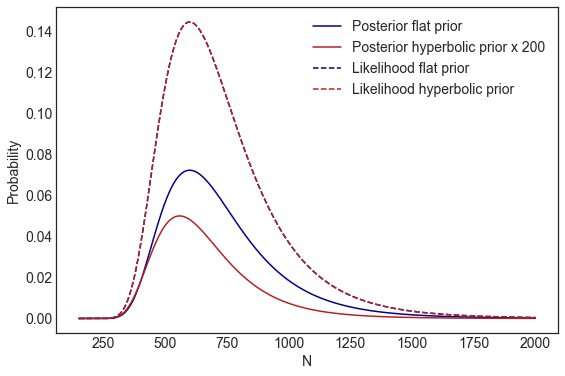

In [28]:
likelihoods_hyper, posteriors_hyper = posterior(N, k, K, n, 1/N, 1)

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(N,posteriors_k10, label='Posterior flat prior', c='darkblue')
ax.plot(N,posteriors_hyper*200, label='Posterior hyperbolic prior x 200', c='firebrick')
ax.plot(N,likelihoods_k10, label='Likelihood flat prior', linestyle='dashed', c='darkblue')
ax.plot(N,likelihoods_hyper, label='Likelihood hyperbolic prior', linestyle='dashed', c='firebrick')
ax.set_xlabel('N')
ax.set_ylabel('Probability')
ax.legend()

In [ ]:
# The estimator of N does not differ between the likelihood and the Bayesian 
# posterior for a flat prior, but it does for a hyperbolic prior.

## Exercise Fish

In [37]:
K_fish = 50
n_fish = 30
k_fish = 4

N_fish = np.linspace(50,1000, 10000)

# Gaussian prior with mean 500 and sigma:
mu_fish = 500
sigma_fish = np.sqrt((1/10)**2 *300**2 + (5000/10**2)**2)
# The regular error propagation is not exactly true here. The prior is not Gaussian when we have a fraction (5000/10) 
# because 5000/0.9 and 5000/1.1 are not equal distance from the mean, so the distribution already has a bias here. 
# Wikipedia has the more correct error propagation. We can also estimate the error with MC. 


prior_fish = norm.pdf(N_fish, mu_fish, sigma_fish)

likelihoods_fish, posteriors_fish = posterior(N_fish, k_fish, K_fish, n_fish, prior_fish, 1)

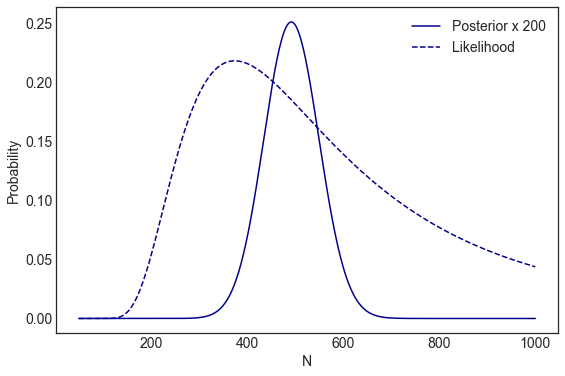

In [41]:
fig, ax = plt.subplots(figsize=(9,6))

ax.plot(N_fish,posteriors_fish*200, label='Posterior x 200', c='darkblue')
ax.plot(N_fish,likelihoods_fish, label='Likelihood', linestyle='dashed', c='darkblue')
ax.set_xlabel('N')
ax.set_ylabel('Probability')
ax.legend()

In [42]:
# changing sigma
sigma_try = np.linspace(20, 80, 4)

likelihoods_sigma = []
posteriors_sigma = []

for s in range(len(sigma_try)):
    prior_s = norm.pdf(N_fish, mu_fish, sigma_try[s])
    likelihoods_s, posteriors_s = posterior(N_fish, k_fish, K_fish, n_fish, prior_s, 1)
    likelihoods_sigma.append(likelihoods_s)
    posteriors_sigma.append(posteriors_s)

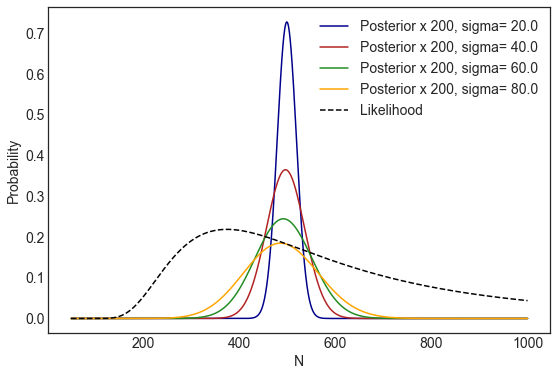

In [46]:
colors = ['darkblue', 'firebrick', 'forestgreen', 'orange']

fig, ax = plt.subplots(figsize=(9,6))

for i in range(4):
    ax.plot(N_fish,posteriors_sigma[i]*200, label=f'Posterior x 200, sigma= {sigma_try[i]}', c=colors[i])

ax.plot(N_fish,likelihoods_sigma[i], label=f'Likelihood', linestyle='dashed', c='k')
ax.set_xlabel('N')
ax.set_ylabel('Probability')
ax.legend()

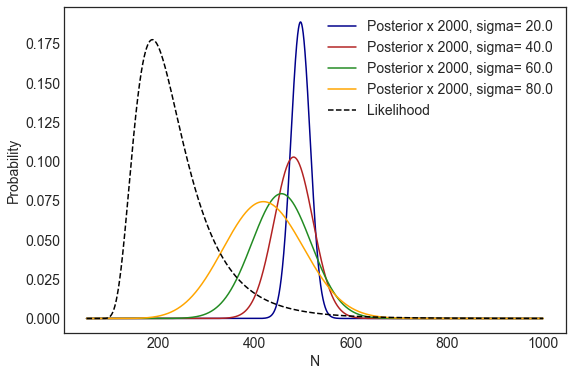

In [50]:
# with k=8
k_fish_new  = 8

likelihoods_sigma_k8 = []
posteriors_sigma_k8 = []

for s in range(len(sigma_try)):
    prior_s = norm.pdf(N_fish, mu_fish, sigma_try[s])
    likelihoods_s, posteriors_s = posterior(N_fish, k_fish_new, K_fish, n_fish, prior_s, 1)
    likelihoods_sigma_k8.append(likelihoods_s)
    posteriors_sigma_k8.append(posteriors_s)
    
colors = ['darkblue', 'firebrick', 'forestgreen', 'orange']

fig, ax = plt.subplots(figsize=(9,6))

for i in range(4):
    ax.plot(N_fish,posteriors_sigma_k8[i]*2000, label=f'Posterior x 2000, sigma= {sigma_try[i]}', c=colors[i])

ax.plot(N_fish,likelihoods_sigma_k8[i], label=f'Likelihood', linestyle='dashed', c='k')
ax.set_xlabel('N')
ax.set_ylabel('Probability')
ax.legend()

In [61]:
# How the uncertainty impacts how close the posterior estimate is to the likelihood estimate

# k=8
N_likelihood_est8 = N_fish[np.argmax(likelihoods_sigma_k8[0])]
N_posterior_est8 = np.array([N_fish[np.argmax(posteriors_sigma_k8[i])] for i in range(4)])

print('Differences in estimates (k=8):', N_posterior_est8-N_likelihood_est8)

# k=4
N_likelihood_est4 = N_fish[np.argmax(likelihoods_sigma[0])]
N_posterior_est4 = np.array([N_fish[np.argmax(posteriors_sigma[i])] for i in range(4)])

print('Differences in estimates (k=4):', N_posterior_est4-N_likelihood_est4)

Differences in estimates (k=8): [308.30583058 293.76937694 268.59185919 230.87308731]
Differences in estimates (k=4): [124.55745575 121.80218022 117.33673367 111.25612561]


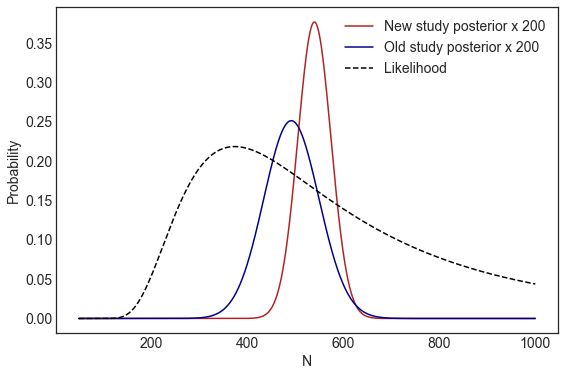

In [59]:
# Now use N = 9.2 +- 0.2

mu_fish_new = 5000/9.2
sigma_fish_new = np.sqrt((1/9.2)**2 *300**2 + (5000/9.2**2)**2*0.2**2)
prior_fish_new = norm.pdf(N_fish, mu_fish_new, sigma_fish_new)

likelihoods_fish_new, posteriors_fish_new = posterior(N_fish, k_fish, K_fish, n_fish, prior_fish_new, 1)

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(N_fish,posteriors_fish_new*200, label='New study posterior x 200', c='firebrick')
ax.plot(N_fish,posteriors_fish*200, label='Old study posterior x 200', c='darkblue')
ax.plot(N_fish,likelihoods_fish, label='Likelihood', linestyle='dashed', c='k')
ax.set_xlabel('N')
ax.set_ylabel('Probability')
ax.legend()

In [ ]:
# The posteriors and likelihoods don't really agree... 
# But priors can still be good. Sometimes the likelihood doesn't tell much, but when including a prior, 
# we get alot more information and can get more precise estimates. If the prior is very well justified, it can really improve the estimates.

# Splines